# Recommenders 4 : Pytorch and Recommenders (~1h)

In this practical session, we dive a little more into [pytorch](https://pytorch.org/docs/stable/index.html) and propose to re-implement two classical matrix-factorization models with this neural network toolkit.

## Objectives:

- (a) See a bit of simple pytorch (~5min)
- (b) Discover the "autograd" part of pytorch to build a simple baseline (~20min)
- (c) Discover the "nn" part of pytorch to build a simple matrix factorization algorithm (~20min)
- (d) Learn to use a high level framework for pytorch (kind of "KERAS" like) to build more complicated algorithms (~15min)




In [1]:
! pip install torch torchvision pytorch-lightning --upgrade
! pip install matplotlib --upgrade

     |████████████████████████████████| 119.6 MB 46.8 MB/s eta 0:00:01  |█▏                              | 4.5 MB 5.2 MB/s eta 0:00:23     |████████████████▉               | 62.9 MB 22.0 MB/s eta 0:00:03
     |████████████████████████████████| 13.2 MB 17.8 MB/s eta 0:00:01
     |████████████████████████████████| 829 kB 21.8 MB/s eta 0:00:01
     |████████████████████████████████| 829 kB 18.4 MB/s eta 0:00:01
     |████████████████████████████████| 269 kB 42.0 MB/s eta 0:00:01
     |████████████████████████████████| 10.6 MB 34.7 MB/s eta 0:00:01
     |████████████████████████████████| 103 kB 28.1 MB/s eta 0:00:01
     |████████████████████████████████| 74 kB 6.7 MB/s  eta 0:00:01
  Using cached typing_extensions-3.7.4.3-py3-none-any.whl (22 kB)
     |████████████████████████████████| 648 kB 12.4 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 15.6 MB/s eta 0:00:01     |██████████████████              | 2.1 MB 15.6 MB/s eta 0:00:01
     |████████████████████████████████| 

  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.1
    Uninstalling matplotlib-3.3.1:
      Successfully uninstalled matplotlib-3.3.1


In [23]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# (a) WHAT IS PYTORCH?

It’s a Python-based scientific computing package targeted at two sets of audiences:

- A replacement for NumPy to use the power of GPUs
- a deep learning research platform that provides maximum flexibility and speed

### Tensors : the main unit

Tensors are similar to NumPy’s ndarrays, with the addition being that Tensors can also be used on a GPU to accelerate computing.


## Some useful functions:

### Creating tensors

#### initialize an empty 4x2 matrix

In [24]:
x_empty = torch.empty(4, 2)
print(x_empty)  #Tensor is not initialized => contains gibberish

tensor([[2.1019e-44, 0.0000e+00],
        [0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00]])


#### create a 3x2 tensor filled with zeros of type long

In [25]:
x0 = torch.zeros(3, 2, dtype=torch.long)
print(x0) #Tensor has only zeros

tensor([[0, 0],
        [0, 0],
        [0, 0]])


#### create a tensor of size 2 with (0 => 5.5) and (1 => 3)

In [26]:
x_data = torch.tensor([5.5, 3])
print(x_data) 

tensor([5.5000, 3.0000])


In [27]:
x_data = torch.tensor(np.array([5.5, 3])) #also works with numpy arrays
print(x_data) 

tensor([5.5000, 3.0000], dtype=torch.float64)


#### create random 5x3 and 3x5 tensors 

In [28]:
x = torch.rand(5,3)
y = torch.rand(3,5)
print(x)

tensor([[0.5283, 0.8717, 0.6568],
        [0.9527, 0.9021, 0.0667],
        [0.2179, 0.0246, 0.4431],
        [0.1012, 0.9802, 0.1448],
        [0.6364, 0.3324, 0.3857]])


#### Indexing works just like numpy 

In [29]:
x[:,1] #The 2nd column (indexing starts at 0)

tensor([0.8717, 0.9021, 0.0246, 0.9802, 0.3324])

In [30]:
x[[1,3],:] # the 2nd and 4th row 

tensor([[0.9527, 0.9021, 0.0667],
        [0.1012, 0.9802, 0.1448]])

In [31]:
scalar = torch.tensor([1])
print(scalar.item()) # Gets the value when tensor is a scalar

1


#### know the size of a tensor

In [32]:
x.size() ## equivalent to x.shape in numpy

torch.Size([5, 3])

#### simple addition

In [33]:
x+1        # same as x.add(1)
x.add_(1)  # inplace

tensor([[1.5283, 1.8717, 1.6568],
        [1.9527, 1.9021, 1.0667],
        [1.2179, 1.0246, 1.4431],
        [1.1012, 1.9802, 1.1448],
        [1.6364, 1.3324, 1.3857]])

#### matrix multiplication

In [34]:
torch.mm(x,y) # same as x @ y or np.dot(x.numpy(),y.numpy())

tensor([[1.9293, 2.9642, 1.5680, 0.4155, 2.2434],
        [1.6849, 2.7233, 1.5736, 0.2850, 1.9592],
        [1.5314, 2.0201, 0.9843, 0.3584, 1.8633],
        [1.4751, 2.6686, 1.5037, 0.2897, 1.6121],
        [1.6863, 2.3437, 1.2246, 0.3526, 2.0382]])

### What to understand:

Pytorch can be a drop-in replacement for numpy. It behaves mostly the same and the API is close.


### There are many more creation/operation ops:

=> You can have a look at the [torch.Tensor documentation](https://pytorch.org/docs/stable/tensors.html)

## What's interesting beyond the "numpy replacement": autodiff !

Pytorch has Automatic differentiation: You only have to compute a loss function to obtain gradients automatically. How it works is detailed [here](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#pytorch-tensors-and-autograd)

### Let's do 1d-linear regression with the vanilla autodiff !

#### (First) we need fake data:

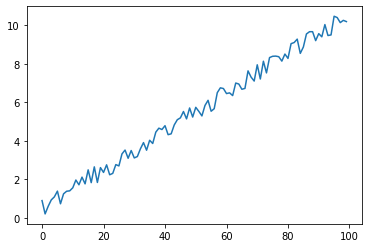

In [35]:
fake_x = np.arange(0,100,1)
fake_y = np.arange(0,10,0.1) + np.random.rand(100)
plt.plot(fake_x,fake_y)

**NOTE:** Here, we won't split the data in train/val/test, this is just an example

So, the linear model we want to learn is the following:
$$f(x) =  wx+b $$
The parameters to optimize are w and b.

In [62]:
# First we create to tensor variables (which are our parameters)
w = torch.tensor([1.],requires_grad=True) # We need to set requires_grad to True so the gradient can flow.
b = torch.tensor([0.5],requires_grad=True)

tensor([1.], requires_grad=True) tensor([0.5000], requires_grad=True)


In [67]:
# We define the f function:
def f(x):
    return (w*x)+b

In [68]:
# We define an error function (here the MAE)
def error(pred,real):
    return (pred-real).abs()

----
loss: 0.3386442530155182
w: 0.10660025477409363
b: 0.4888014793395996
----
loss: 0.38207367300987244
w: 0.09800027310848236
b: 0.4888014793395996
----
loss: 0.3538042640686035
w: 0.10220028460025787
b: 0.4894014000892639
----
loss: 0.35267513692379
w: 0.10220029950141907
b: 0.48960137367248535


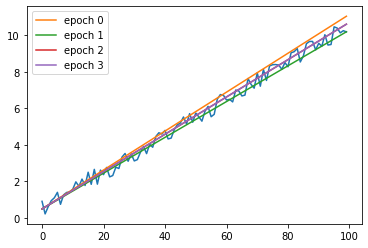

In [69]:
# Finally, we cycle through the data, optimizing the parameters with respect to the gradient of the error:
plt.plot(fake_y)

for epoch in range(4): # We cycle 4 times
    mean_loss = 0
    for x,y in zip(fake_x,fake_y): 
        pred = f(x) #predict
        loss = error(pred,y) #compute loss
        loss.backward() # This does backpropagation and sets .grad attribute.

        # Update parameters via SGD:
        with torch.no_grad(): # This deactivated gradient calculations
            
            mean_loss += loss.item() # get the raw value of a (1,) tensor
            w -= 0.0001 * w.grad # This wouldn't be possible w/ gradient (-= is an inplace operation)
            b -= 0.0001 * b.grad
            w.grad.zero_()
            b.grad.zero_()
            
    # Plot the resulting line     
    predictions = [f(x).detach().numpy() for x in range(100)]
    plt.plot(predictions,label=f"epoch {epoch}")
    print('----')
    print("loss:", mean_loss/len(fake_y))
    print('w:',w.item())
    print('b:',b.item())
    
plt.legend()


# Full pytorch tutorial: 

A tutorial can be found [here](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) do not hesitate to take a couple of minutes to skim read it. Plenty of [ressources](https://pytorch.org/resources) are available online. Also, you can have a look at the [extensive pytorch documentation](https://pytorch.org/docs/stable/index.html). 

Here, as we are defining neural networks, we mainly use the `torch.nn` module which contains most classical deep learning building blocks



## Data used : [smallest movie-lens dataset](https://grouplens.org/datasets/movielens/)

=> Just like the previous sessions


# 1)  Load & Prepare Data

To be able to embed the data easily, we need to remap  the user/items between [0->N_User] and [0->N_Items].

In [156]:
from random import shuffle

## Load
ratings = pd.read_csv("dataset/ratings.csv")
print(ratings.head(5))
## Prepare Data
user_map = {user:num for num,user in enumerate(ratings["userId"].unique())}
item_map = {item:num for num,item in enumerate(ratings["movieId"].unique())}

## Number of users & items
num_users = len(user_map)
num_items = len(item_map)

ratings["userId"] = ratings["userId"].map(user_map)
ratings["movieId"] = ratings["movieId"].map(item_map)


# Creating Test/Train as before

train_indexes,val_indexes,test_indexes = [],[],[]

for index in range(len(ratings)):
    if index%5 == 0:
        test_indexes.append(index)
    else:
        train_indexes.append(index)

        
shuffle(train_indexes)
num_val = int(len(train_indexes)/100*20)
val_indexes = train_indexes[:num_val]
train_indexes = train_indexes[num_val:]

train_ratings = ratings.iloc[train_indexes].copy()
val_ratings = ratings.iloc[val_indexes].copy()
test_ratings = ratings.iloc[test_indexes].copy()

print(f" #train:{len(train_ratings)}, #val:{len(val_ratings)} ,#test:{len(test_ratings)}" )



SyntaxError: invalid syntax (<ipython-input-156-fb69dc967d20>, line 9)

## (TODO) Reproduce the baseline model with pytorch's vanilla autograd

Your goal now is to reproduce the following baseline model from surprise

## $$\hat{r}_{ui} = b_{ui} = \mu + b_u + b_i$$

## (TODO) : First, let's define the parameters

You have many parameters, they are all 1-dimensional:
- **mu:** the global mean (1,)
- **bu:** the user means (n_users,)
- **bi:** the item means (n_items,)


In [206]:
import math

mu = torch.tensor(train_ratings['rating'].mean(),requires_grad=True)
print(mu)
bu = [ torch.tensor(train_ratings.loc[train_ratings['userId'] == u]['rating'].mean(),requires_grad=True) for u in range(num_users)]
bi = []
for i in range(num_items):
    moy = train_ratings.loc[train_ratings['movieId'] == L[i]]['rating'].mean()
    if(not math.isnan(moy)):
        bi.append(torch.tensor(moy,requires_grad=True))
    else:
        bi.append(torch.tensor(0.,requires_grad=True))


tensor(3.5001, dtype=torch.float64, requires_grad=True)



Then, we define two functions: 

- `predict(u,i)` : Will return the prediction given the (user,item) pair
- `error(pred,real)` : Will return the MSE error of prediction

#### (TODO) Predict Function
This function should implement this: $\hat{r}_{ui} = b_{ui} = \mu + b_u + b_i$

In [207]:
def predict(u,i):
    
    if u < num_users: # if user exist:
        user_mean = bu[u]
    else:
        user_mean = 0
        
    if i < num_items: # if item exist:
        item_mean = bi[i]
    else:
        item_mean = 0
        
    return mu.item()+user_mean+item_mean

### (TODO) error function
We want to use the MSE

In [208]:
def error(pred,real):
    return (pred-real)**2 

#### The evaluation loop, without any optimization for now

In [209]:
train_e = 0
for index, uid, mid, r, ts in train_ratings.itertuples():
    result = predict(uid,mid)
    train_e += error(result,r).item()
    
val_e = 0
for index, uid, mid, r, ts in val_ratings.itertuples():
    result = predict(uid,mid)
    val_e += error(result,r).item()

test_e = 0
for index, uid, mid, r, ts in test_ratings.itertuples():
    result = predict(uid,mid)
    test_e += error(result,r).item()

print("final train error : ", train_e/len(train_ratings))
print("final val error : ", val_e/len(val_ratings))
print("final test error : ", test_e/len(test_ratings))

final train error :  38.76785971837357
final val error :  38.96689720459835
final test error :  38.737803739685354


## Let's optimize the parameters (with SGD)  by slightly modifying the previous loop

### (TODO)


In [213]:
lr = 0.01
batch_size = 32
n_epochs = 5

for epoch in range(n_epochs):
    
    train_error = 0
    
    for num,(index, uid, mid, r, ts) in enumerate(train_ratings.sample(frac=1).itertuples()):
        result = predict(uid,mid)
        ex_error =error(result,r)
        train_error +=  ex_error
        
        ex_error.backward()

        if num % batch_size == 0:
            
            with torch.no_grad():
                bu[uid] -= 0.0001 * bu[uid].grad
                bi[mid] -= 0.0001 * bi[mid].grad

                # Manually zero the gradients after updating weights
                bu[uid].grad.zero_()
                bi[mid].grad.zero_()


    print(f"epoch {epoch} train error : ", train_e/len(train_ratings))
    
    val_e = 0
    for index, uid, mid, r, ts in val_ratings.itertuples():
        result = predict(uid,mid)
        val_e += error(result,r).item()

    print(f"epoch {epoch} val error : ", val_e/len(val_ratings))


    test_e = 0
    for index, uid, mid, r, ts in test_ratings.itertuples():
        result = predict(uid,mid)
        test_e += error(result,r).item()

    print(f"epoch {epoch} test error : ", test_e/len(test_ratings))
    print("-----")

epoch 0 train error :  38.76785971837357
epoch 0 val error :  34.54314793229203
epoch 0 test error :  34.323287068776445
-----
epoch 1 train error :  38.76785971837357
epoch 1 val error :  30.65322955083963
epoch 1 test error :  30.451557919609588
-----
epoch 2 train error :  38.76785971837357
epoch 2 val error :  27.642443777926072
epoch 2 test error :  27.440557042533978
-----
epoch 3 train error :  38.76785971837357
epoch 3 val error :  25.140626557769068
epoch 3 test error :  24.94180524865986
-----
epoch 4 train error :  38.76785971837357
epoch 4 val error :  23.10409574296881
epoch 4 test error :  22.90651464725815
-----


#  Pytorch (.nn) Modules

Instead of having to define everything by hand, pytorch has several usefull abstractions:

- `nn.Module()` -> To define the model and the forward computation
- `torch.utils.data.DataLoader` -> To create the data pipeline

To explore these modules, we'll do the following model:

##  Classic SVD (with mean)

To see how it works, we propose to implement a simple SVD:
### $$ \min\limits_{U,I}\sum\limits_{(u,i)} \underbrace{(r_{ui} -  (I_i^TU_u + \mu))^2}_\text{minimization} + \underbrace{\lambda(||U_u||^2+||I_u||^2 + \mu) }_\text{regularization} $$

where prediction is done in the following way:
### $$r_{ui} = \mu + U_u.I_i $$

where $\mu$ is the global mean,  $U_u$ a user embedding and $I_i$ an item embedding

### STEPS:
 To implement such model in pytorch, we need to do multiple things:
 
 - (1) model definition
 - (2) loss function
 - (3) evaluation
 - (4) training/eval loop


#### (1) Model definition

A model class typically extends `nn.Module`, the Neural network module. It is a convenient way of encapsulating parameters, with helpers for moving them to GPU, exporting, loading, etc.

One should define two functions: `__init__` and `forward`.

- `__init__` is used to initialize the model parameters
- `forward` is the net transformation from input to output. In fact, when doing `moduleClass(input)` you call this method.

##### (a) Initialization

Our model has different weigths:

- the user profiles (also called user embeddings) $U$
- the item profiles (also called user embeddings) $I$
- the mean bias $\mu$


##### (b) input to output operation
Technically, the prediction as defined earlier can be seen as just a dot product between two embeddings $U_u$ and $I_i$ plus the mean rating:

- `torch.sum(embed_u*embed_i,1) + self.mean` is equivalent to $r_{ui} = \mu + U_u.I_i $ 
- the `.squeeze(1)` operation is a shape operation to remove the dimension 1 (indexing starts at 0) akin to reshaping the matrix from `(batch_size,1,latent_size)` to `(batch_size,latent_size)`
- for reference, the inverse operation is `.unsqueeze()`
- we return weights to regularize them


### (TODO) Just to make sure you were following: complete the following `forward` method

In [214]:
#  Let's create the datasets following  (Object w/ __getitem__(index) and __len()__, i.e lists ;)
prep_train = [(tp.userId,tp.movieId,tp.rating) for tp in train_ratings.itertuples()]
prep_val = [(tp.userId,tp.movieId,tp.rating) for tp in val_ratings.itertuples()]
prep_test = [(tp.userId,tp.movieId,tp.rating) for tp in test_ratings.itertuples()]

In [ ]:
import torch
import torch.nn as nn


# The model define as a class, inheriting from nn.Module
class ClassicMF(nn.Module):
    
    #(a) Init
    def __init__(self,nb_users,nb_items,latent_size):
        super(ClassicMF, self).__init__()
        
        #Embedding layers
        self.users = nn.Embedding(#To Complete, latent_size)        
        self.items = nn.Embedding(#To Complete, latent_size)
        #The mean bias
        self.mean = nn.Parameter(torch.FloatTensor(1,).fill_(3))
        
        #initialize weights with very small values
        nn.init.normal_(self.users.weight,0,0.01)
        nn.init.normal_(self.items.weight,0,0.01)

    
    # (b) How we compute the prediction (from input to output)
    def forward(self, user, item): ## method called when doing ClassicMF(user,item)
        
        embed_u,embed_i = self.users(user).squeeze(1),self.items(item).squeeze(1)
        out =  #To Complete

        return out, embed_u, embed_i, self.mean  # We return prediction + weights to regularize them
    
    

#### (2-4) full train loop

The train loop is organized around the [Dataloader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) class which Combines a dataset and a sampler, and provides single- or multi-process iterators over the dataset.

We just redefine a collate function

> collate_fn (callable, optional) – merges a list of samples to form a mini-batch.


**NOTE:** The dataset argument can be a list instead of a "Dataset" instance (works by duck typing)
    

##### The train loop sequence is the following:
    
[Dataset ==Dataloader==> Batch (not prepared) ==collate_fn==> Batch (prepared) ==Model.forward==> Prediction =loss_fn=> loss <-> truth 

1] PREDICT
- (a) The dataloader samples training exemples from the dataset (which is a list)
- (b) The collate_fn prepares the minibatch of training exemples
- (c) The prediction is made by feeding the minibatch in the model
- (d) The loss is computed on the prediction via a loss function

2] OPTIMIZE
- (e) Gradients are computed by automatic backard propagation
- (f) Parameters are updated using computed gradients

In [ ]:
from torch.utils.data import DataLoader
import torch.nn.functional as F


# HyperParameters
n_epochs = 3
batch_size = 16
num_feat = 25
lr = 0.01
reg = 0.001


#(b) Collate function => Creates tensor batches to feed model during training
# It can be removed if data is already tensors (torch or numpy ;)
def tuple_batch(l):
    '''
    input l: list of (user,item,rating tuples)
    output: formatted batches (in torch tensors)

    takes n-tuples and create batch
    text -> seq word #id
    '''
    users, items, ratings = zip(*l) 
    users_t = torch.LongTensor(users)
    items_t = torch.LongTensor(items)
    ratings_t = torch.FloatTensor(ratings)
    
    return users_t, items_t, ratings_t
    


#(d) Loss function => Combines MSE and L2
def loss_func(pred,ratings_t,reg,*params):
    '''
    mse loss combined with l2 regularization.
    params assumed 2-dimension
    '''
    mse = F.mse_loss(pred,ratings_t,reduction='sum')
    l2 = 0
    for p in params:
        l2 += torch.mean(p.norm(2,-1))
        
    return (mse/pred.size(0)) + reg*l2 , mse
    
#
# Training script starts here
#    


model = ClassicMF(num_users,num_items,num_feat)



# (a) dataloader will sample data from datasets using collate_fn tuple_batch
dataloader_train = DataLoader(prep_train, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=tuple_batch)
dataloader_val = DataLoader(prep_val, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=tuple_batch)
dataloader_test = DataLoader(prep_test, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=tuple_batch)

optimizer = torch.optim.Adam(model.parameters())

# Train loop
for e in range(n_epochs):
    mean_loss = [0,0,0] #train/val/test

    ## Training loss (the one we train with)
    
    for users_t,items_t,ratings_t in dataloader_train:
        model.train() # set the model on train mode
        model.zero_grad() # reset gradients
        
        #(c) predictions are made by the model
        pred,*params = model(users_t,items_t)
        
        #(d) loss computed on predictions, we added regularization
        loss,mse_loss = loss_func(pred,ratings_t,reg,*params)
        
        loss.backward() #(e) backpropagating to get gradients
        
        mean_loss[0] += mse_loss
        optimizer.step() #(f) updating parameters
    
    with torch.no_grad():
        ## Validation loss (no training)
        for users_t,items_t,ratings_t in dataloader_val:

            model.eval() # Inference mode
            pred,*params = model(users_t,items_t)
            _,mse_loss = loss_func(pred,ratings_t,reg,*params)

            mean_loss[1] += mse_loss    

        ## Test loss (no training)

        for users_t,items_t,ratings_t in dataloader_test:
            model.eval()
            pred,*params = model(users_t,items_t)
            _,mse_loss = loss_func(pred,ratings_t,reg,*params)

            mean_loss[2] += mse_loss    

    print("-"*25)
    print("epoch",e, "mse (train/val/test)", round((mean_loss[0]/len(prep_train)).item(),3),"/",  round((mean_loss[1]/len(prep_val)).item(),3),"/",  round((mean_loss[2]/len(prep_test)).item(),3))
    
    

## (Your turn) Koren 2009 model:

Here, this model simply adds a bias for each user and for each item

### $$ \min\limits_{U,I}\sum\limits_{(u,i)} \underbrace{(r_{ui} -  (I_i^TU_u + \mu+ \mu_i+\mu_u))^2}_\text{minimization} + \underbrace{\lambda(||U_u||^2+||I_u||^2 + \mu  + \mu+ \mu_i+\mu_u) }_\text{regularization} $$


### $$r_{ui} = \mu + \mu_i + \mu_u + U_u.I_i $$

### TODO:

- (a) complete the model initialization
- (b) complete the forward method

In [ ]:
class KorenMF(nn.Module):

    def __init__(self,nb_users,nb_items,latent_size):
        super(KorenMF, self).__init__()
        
        self.users = #To Complete
        self.items = #To Complete
        self.umean = #To Complete
        self.imean = #To Complete
        self.gmean =  #To Complete

        nn.init.normal_(self.users.weight,0,0.01)
        nn.init.normal_(self.items.weight,0,0.01)
        nn.init.normal_(self.umean.weight,2,1)
        nn.init.normal_(self.imean.weight,2,1)
        
        
    def forward(self, user,item):
        embed_u,embed_i = self.users(user).squeeze(1) , self.items(item).squeeze(1)
        umean, imean = self.umean(user) , self.imean(item)
        out = #To Complete

        return out , embed_u, embed_i, umean , imean , self.gmean

### (TODO) Here, train loop stays the same, you only have to change the model

In [ ]:
from torch.utils.data import DataLoader
import torch.nn.functional as F

n_epochs = 10
batch_size = 16
num_feat = 25
lr = 0.01
reg = 0.001



def tuple_batch(l):
    '''
    input l: list of (user,item,review, rating tuples)
    output: formatted batches (in torch tensors)

    takes n-tuples and create batch
    text -> seq word #id
    '''
    users, items,ratings = zip(*l)
    users_t = torch.LongTensor(users)
    items_t = torch.LongTensor(items)
    ratings_t = torch.FloatTensor(ratings)
    
    return users_t,items_t,ratings_t


def loss_func(pred,ratings_t,reg,*params):
    '''
    mse loss combined with l2 regularization.
    params assumed 2-dimension
    '''
    mse = F.mse_loss(pred,ratings_t,reduction="sum")
    l2 = 0
    for p in params:
        l2 += torch.mean(p.norm(2,-1))
        
    return (mse/pred.size(0)) + reg*l2 , mse
    

model =  #To Complete


dataloader_train = DataLoader(prep_train, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=tuple_batch)
dataloader_val = DataLoader(prep_val, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=tuple_batch)
dataloader_test = DataLoader(prep_test, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=tuple_batch)

optimizer = torch.optim.Adam(model.parameters())


for e in range(n_epochs):
    mean_loss = [0,0,0] #train/val/test

    for users_t,items_t,ratings_t in dataloader_train:
        model.train()
        model.zero_grad()
        pred,*params = model(users_t,items_t)

        loss,mse_loss = loss_func(pred,ratings_t,reg,*params)
        loss.backward()
        
        mean_loss[0] += mse_loss
        optimizer.step()
    
    

    for users_t,items_t,ratings_t in dataloader_val:
        model.eval()
        pred,*params = model(users_t,items_t)
        _,mse_loss = loss_func(pred,ratings_t,reg,*params)
    
        mean_loss[1] += mse_loss    
        
    for users_t,items_t,ratings_t in dataloader_test:
        model.eval()
        pred,*params = model(users_t,items_t)
        _,mse_loss = loss_func(pred,ratings_t,reg,*params)
    
        mean_loss[2] += mse_loss    

    print("-"*25)
    print("epoch",e, "mse (train/val/test)", round((mean_loss[0]/len(prep_train)).item(),3),"/",  round((mean_loss[1]/len(prep_val)).item(),3),"/",  round((mean_loss[2]/len(prep_test)).item(),3))
    
    

## Pytorch's keras: Pytorch-Lightning

Pytorch lightning is a easy to use framework for Pytorch. To start a new project you just need to define two files:

- a LightningModule (which inherits `pl.LightningModule`)
- a Trainer file. 

By defining those two files, you get:
- Checkpointing
- Debugging
- Distributed training
- Experiment Logging
- Training loop
- Validation loop
- Testing loop

## Let's try with the same but different Koren 2009 model:


### $$r_{ui} = \mu + \mu_i + \mu_u + U_u.I_i $$

Where the goal is to minimize the following loss

### $$ \min\limits_{U,I}\sum\limits_{(u,i)} \underbrace{(r_{ui} -  (I_i^TU_u + \mu+ \mu_i+\mu_u))^2}_\text{minimization} + \underbrace{\lambda(||U_u||^2+||I_u||^2 + \mu  + \mu+ \mu_i+\mu_u) }_\text{regularization} $$




## (TODO) Complete the code

In [ ]:
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import pytorch_lightning as pl

class LightningKorenMF(pl.LightningModule):

    def __init__(self,nb_users,nb_items,latent_size):
        super(LightningKorenMF, self).__init__()
        
        self.reg = 0.001
        
        self.users = #To Complete
        self.items = #To Complete
        self.umean = #To Complete
        self.imean = #To Complete
        self.gmean =  nn.Parameter(torch.FloatTensor(1,).fill_(3))

        nn.init.normal_(self.users.weight,0,0.01)
        nn.init.normal_(self.items.weight,0,0.01)
        nn.init.normal_(self.umean.weight,0.1,0.1)
        nn.init.normal_(self.imean.weight,0.1,0.1)
        

    def forward(self, user,item):
        embed_u,embed_i = self.users(user).squeeze(1) , self.items(item).squeeze(1)
        umean, imean = self.umean(user) , self.imean(item)
        out = #To Complete

        return out , embed_u, embed_i, umean , imean , self.gmean

    
    def my_loss_func(self, pred,ratings_t,reg,*params):
        '''
        mse loss combined with l2 regularization.
        params assumed 2-dimension
        '''        
        mse = F.mse_loss(pred,ratings_t)
        l2 = 0
        for p in params:
            l2 += torch.mean(p.norm(2,-1))

        return mse + reg*l2 , mse
    
    def training_step(self, batch, batch_nb):
        # REQUIRE
        users_t,items_t,ratings_t = batch
        pred , *params = self.forward(users_t,items_t) 
        loss,mse = self.my_loss_func(pred,ratings_t,self.reg,*params)

        return {'loss':loss,"mse":mse}
    

    
    def validation_step(self, batch, batch_nb):
        return {"val_mse":self.training_step(batch,batch_nb)["mse"]}
    
    def validation_end(self,outputs):
        return {"progress_bar":{"val_mse":torch.tensor([output['val_mse'] for output in outputs]).mean().item()}}
    
    def test_step(self, batch, batch_nb):
        return {"test_mse":self.training_step(batch,batch_nb)["mse"]}
    
    def test_end(self,outputs):
        res = {"progress_bar":{"test_mse":torch.tensor([output['test_mse'] for output in outputs]).mean().item()}}
        print(res)
        return res

    
    def configure_optimizers(self):
        # REQUIRED
        return torch.optim.Adam(self.parameters(), lr=0.002)
    
    def tuple_batch(self,l):
        '''
        input l: list of (user,item,rating tuples)
        output: formatted batches (in torch tensors)

        takes n-tuples and create batch
        text -> seq word #id
        '''
        users, items, ratings = zip(*l) 
        users_t = torch.LongTensor(users)
        items_t = torch.LongTensor(items)
        ratings_t = torch.FloatTensor(ratings)

        return users_t, items_t, ratings_t
    

    @pl.data_loader
    def train_dataloader(self):
        # REQUIRED
        return DataLoader(prep_train,collate_fn=self.tuple_batch ,num_workers=0, batch_size=32)

    @pl.data_loader
    def val_dataloader(self):
        # OPTIONAL
        return DataLoader(prep_val,collate_fn=self.tuple_batch,num_workers=0, batch_size=32)

    @pl.data_loader
    def test_dataloader(self):
        # OPTIONAL
        return DataLoader(prep_test,collate_fn=self.tuple_batch,num_workers=0, batch_size=32)

## Train the model

In [ ]:
from pytorch_lightning import Trainer

model = LightningKorenMF(num_users,num_items,50)

# most basic trainer, uses good defaults
trainer = Trainer()    
trainer.fit(model)
trainer.test()

## Still got time ?

[Take a glance at the documentation](https://williamfalcon.github.io/pytorch-lightning/)